# **Airbnb Data Cleaning Notebook**

## Objectives

* Have data evalueted for any missing value, and then cleaning data if necessary.  

## Inputs

* Use the data processed that was collected from Kaggle `outputs/datasets/collection/AirbnbEuropeanCities.csv`. 

## Outputs

* Have both, Train and Test set generated and saved under `outputs/datasets/cleaned`.   

---

# Change working directory

Have the working directory changed from its current folder to its parent folder.
* We access the current directory with `os.getcwd()`.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices/jupyter_notebooks'

Have the parent of the current directory set up as the new current directory.
* `os.path.dirname()` gets the parent directory;
* `os.chir()` defines the new current directory.

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Have the new current directory confirmed.

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/europe-airbnb-prices'

---

# Loading Data 

* Have data loaded for the next steps of the analysis process.

In [5]:
import pandas as pd
df = pd.read_csv(f"outputs/datasets/collection/EuropeanCitiesAirbnb.csv")
df.head(10)

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
0,Amsterdam,1,Private room,4.763,0.852,319.64,1
1,Amsterdam,1,Private room,5.748,3.652,348.00,1
2,Amsterdam,2,Private room,0.385,0.440,482.98,1
3,Amsterdam,1,Private room,0.545,0.319,485.55,1
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1
5,Amsterdam,2,Entire home/apt,3.719,1.196,1001.80,1
6,Amsterdam,1,Entire home/apt,1.808,1.902,393.46,1
7,Amsterdam,1,Private room,3.142,0.924,287.77,1
8,Amsterdam,1,Entire home/apt,1.010,0.917,909.47,1
9,Amsterdam,1,Private room,2.183,1.590,393.46,1


* Have data filtered according to the analysis requirements.

In [8]:
# vars_to_corr = ['daily_price', 'bedrooms', 'city_center_dist_km', 'metro_dist_km']
cities_of_interest = ['Amsterdam', 'Barcelona', 'London']
# columns_to_include = vars_to_corr
df_analysis = df[(df['city'].isin(cities_of_interest)) & (df['room_type'] == 'Entire home/apt')]
df_analysis.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1
5,Amsterdam,2,Entire home/apt,3.719,1.196,1001.80,1
6,Amsterdam,1,Entire home/apt,1.808,1.902,393.46,1
8,Amsterdam,1,Entire home/apt,1.010,0.917,909.47,1
10,Amsterdam,1,Entire home/apt,2.933,0.628,553.04,1


# Data Exploration

+ Have variables checked for any missing data.

In [9]:
vars_with_missing_data = df_analysis.columns[df_analysis.isna().sum() > 0].to_list()
vars_with_missing_data

[]

In [10]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


# Correlation and PPS Analysis

**Correlation** and **PPS** were used in this analysis to:
  + `Coorelation`: measure and quantify the strength and direction of the linear relationship between pairs of variables;

  + `PPS`: provide a more comprehensive measure of the relationship between variables, including categorical data and non-linear relationships. It indicates how much one variable can predict another.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df_analysis, threshold, figsize=(10, 6), font_annot=8):
    if len(df_analysis.columns) > 1:
        mask = np.zeros_like(df_analysis, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df_analysis) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df_analysis, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df_analysis.columns, rotation=0)
        plt.ylim(len(df_analysis.columns), 0)
        plt.show()


def heatmap_pps(df_analysis, threshold, figsize=(10, 6), font_annot=8):
    if len(df_analysis.columns) > 1:
        mask = np.zeros_like(df_analysis, dtype=np.bool)
        mask[abs(df_analysis) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df_analysis, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df_analysis.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df_analysis):
    df_corr_spearman = df_analysis.corr(method="spearman")
    df_corr_pearson = df_analysis.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df_analysis)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(10, 6), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df_analysis=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df_analysis=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df_analysis=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

+ Have `Correlations` and `PPS` calculated:

In [19]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_analysis)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore   42.0  0.052  0.122  0.0  0.0  0.0  0.026  0.585


+ Displaying Heatmaps:



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



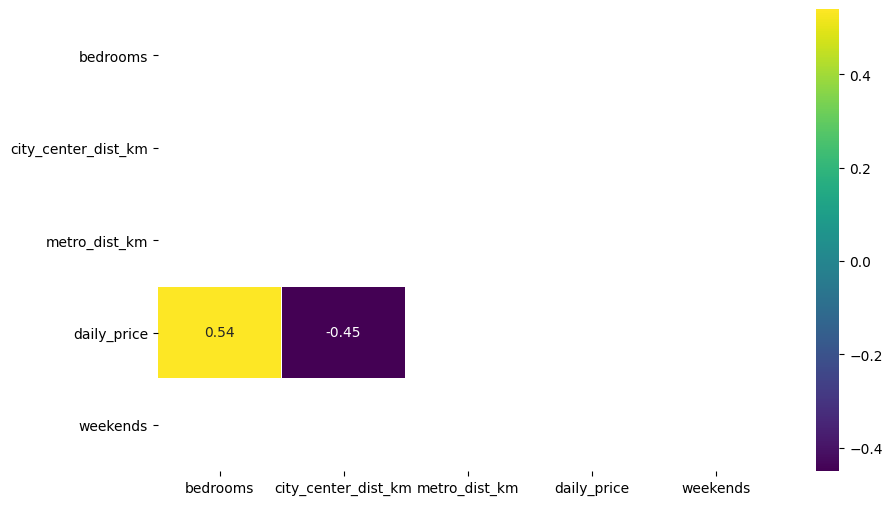



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



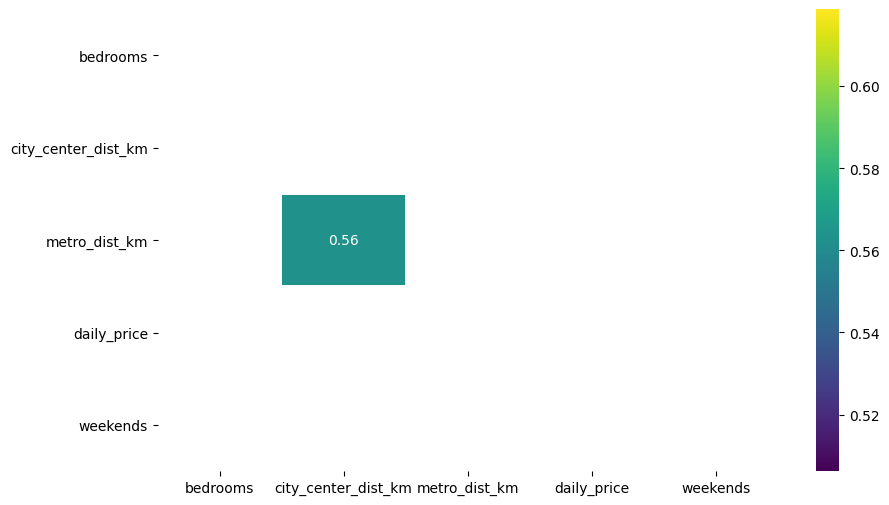



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



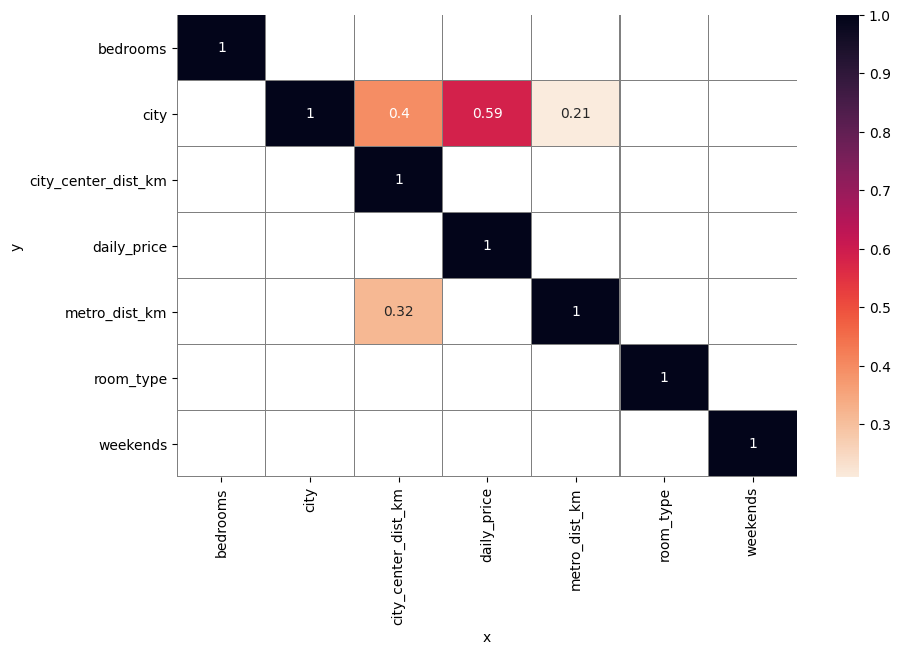

In [24]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(10,6), font_annot=10)

---

# Data Cleaning

As checked above on the `Data Exploration` section, there isn't any missing value in the DataFrame that is being used in the analysis. The only modification we will do is drop the variable `room_type` as this won't be used in the next step of our analysis.

In [27]:
df_analysis.head()

,city,bedrooms,room_type,city_center_dist_km,metro_dist_km,daily_price,weekends
4,Amsterdam,3,Entire home/apt,1.687,1.458,2771.54,1
5,Amsterdam,2,Entire home/apt,3.719,1.196,1001.80,1
6,Amsterdam,1,Entire home/apt,1.808,1.902,393.46,1
8,Amsterdam,1,Entire home/apt,1.010,0.917,909.47,1
10,Amsterdam,1,Entire home/apt,2.933,0.628,553.04,1


In [33]:
def EvaluateMissingData(df_analysis):
    missing_data_absolute = df_analysis.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df_analysis)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df_analysis.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [34]:
EvaluateMissingData(df_analysis)

,RowsWithMissingData,PercentageOfDataset,DataType


In [37]:
from sklearn.model_selection import train_test_split
TrainSetAnalysis, TestSetAnalysis, _, __ = train_test_split(
                                        df_analysis,
                                        df_analysis['daily_price'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (4841, 7) 
TestSet shape: (1211, 7)


In [36]:
df_missing_data = EvaluateMissingData(TrainSetAnalysis)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 0 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType


In [38]:
from feature_engine.selection import DropFeatures
variables_method = ['room_type']
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSetAnalysis)
df_method = imputer.transform(TrainSetAnalysis)


In [39]:
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSetAnalysis)

TrainSetAnalysis, TestSetAnalysis = imputer.transform(TrainSetAnalysis) , imputer.transform(TestSetAnalysis)

In [41]:
EvaluateMissingData(TrainSetAnalysis)

,RowsWithMissingData,PercentageOfDataset,DataType


---

# Pushing File to Repo

* Have new folder created to save the DataFrame that will be used in the next steps of the analysis.

In [21]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') 
except Exception as e:
  print(e)

In [42]:
TrainSetAnalysis.to_csv("outputs/datasets/cleaned/TrainSetAnalysisCleaned.csv", index=False)

In [43]:
TestSetAnalysis.to_csv("outputs/datasets/cleaned/TestSetAnalysisCleaned.csv", index=False)